In [1]:
import os
import glob
import nibabel as nib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import voxelmentations as V


In [27]:
print(dir(V))

['AxialFlip', 'AxialPlaneAffine', 'AxialPlaneDropout', 'AxialPlaneFlip', 'AxialPlaneRotate', 'AxialPlaneScale', 'C', 'DualTransform', 'E', 'F', 'Flip', 'GaussBlur', 'GaussNoise', 'GridDistort', 'HorizontalPlaneDropout', 'Identity', 'IntensityShift', 'M', 'OneOf', 'PadIfNeeded', 'PlaneDropout', 'Sequential', 'VerticalPlaneDropout', 'VoxelOnlyTransform', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'application', 'augmentations', 'compositions', 'core', 'cv2', 'enum', 'functional', 'misc', 'np', 'transforms', 'utils']


## Load in combined tensors and binary mask

In [2]:
combined_tensors = np.load('combined_tensors.npy')

binary_mask = np.load('binary_mask.npy')

print(len(binary_mask))

369


In [3]:
binary_mask = np.expand_dims(binary_mask, axis = -1)

print(len(binary_mask))

binary_mask = np.array(binary_mask)

print(len(binary_mask))

369
369


In [4]:
print(type(combined_tensors))
print(combined_tensors.shape)
print(combined_tensors[0].shape)
print(binary_mask.shape)
print(binary_mask[0].shape)

<class 'numpy.ndarray'>
(369, 128, 128, 128, 3)
(128, 128, 128, 3)
(369, 128, 128, 128, 1)
(128, 128, 128, 1)


## scan augmentation

we want to augment by doing both random rotations, random flips, and random contrast on the scans

axial flips simulate patients being in slightly different positions in the scanner

random gamma simulates the fact that different scanners will have varying contrasts


then save them as 

patient_n_augmented (folder) #note that there is no t1_aug

-patient_n_t1ce_aug.nii

-patient_n_t2_aug.nii

-patient_n_flair_aug.nii

-patient_n_mask_aug.nii

In [12]:
help(V.IntensityShift)

Help on class IntensityShift in module voxelmentations.augmentations.transforms:

class IntensityShift(voxelmentations.core.transforms.VoxelOnlyTransform)
 |  IntensityShift(shift_limit=10.0, per_channel=True, always_apply=False, p=0.5)
 |  
 |  Shift intensities of the voxel.
 |  
 |  Method resolution order:
 |      IntensityShift
 |      voxelmentations.core.transforms.VoxelOnlyTransform
 |      voxelmentations.core.transforms.Transform
 |      voxelmentations.core.application.Apply
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, shift_limit=10.0, per_channel=True, always_apply=False, p=0.5)
 |      :args:
 |          shift_limit: float
 |              limit of intensity shift
 |          per_channel: bool
 |              if set to True, noise will be sampled for each channel independently
 |  
 |  apply(self, voxel, shift, **params)
 |  
 |  get_params_dependent_on_targets(self, params)
 |  
 |  get_transform_init_args_names(self)
 |  
 |  -----------

In [28]:

voxel_augmentations = V.Sequential([
V.IntensityShift(shift_limit=1),
V.AxialPlaneRotate(angle_limit=(100))
])

## create function to do augmentation 

combined and mask must have the same augmentation

In [22]:
def augment_data(combined,mask):
    combined_aug_all = []
    mask_aug_all = []

    for combined, mask in zip (combined,mask):

        augmented = voxel_augmentations(voxel=combined, mask=mask)
        #print(augmented.keys())

        combined_aug_all.append(augmented["voxel"])
        mask_aug_all.append(augmented["mask"])

    return combined_aug_all, mask_aug_all
    

## Create generator for augmentation

In [7]:
def augment_generator(combined,mask, batch_size):
    for i in range(0, len(combined), batch_size):
        combined_batch = combined[i : i + batch_size]
        mask_batch = mask[i : i + batch_size]

        yield combined_batch, mask_batch

## Perform augmentations

In [29]:
augmented_combined = []
augmented_mask = []

for combined_batch, mask_batch in augment_generator(combined_tensors, binary_mask, 4):
    augmented_combined_batch, augmented_mask_batch = augment_data(combined_batch, mask_batch)
    augmented_combined.extend(augmented_combined_batch)
    augmented_mask.extend(augmented_mask_batch)



## Examine augmented

In [98]:
#convert from lists to arrays

augmented_combined = np.array(augmented_combined)
augmented_mask = np.array(augmented_mask)

print(len(augmented_combined))
print(augmented_combined.shape)
print(augmented_combined[0].shape)

print(len(augmented_mask))
print(augmented_mask.shape)
print(augmented_mask[0].shape)

369
(369, 128, 128, 128, 3)
(128, 128, 128, 3)
369
(369, 128, 128, 128, 1)
(128, 128, 128, 1)


## Display augmented images

In [33]:
def view_augmentations(original_combined, augmented_combined, original_mask, augmented_mask):

    slices = 42
    cmap = 'gray'
    plt.figure(figsize=(10,8))
    
    # original voxel
    plt.subplot(2,2,1)
    plt.title('Original Voxel')
    plt.imshow(original_combined[:, :, slices], cmap=cmap)

    #original mask
    plt.subplot(2,2,2)
    plt.title('Original Mask')
    plt.imshow(original_mask[:, :, slices], cmap=cmap)

    # augmented voxel
    plt.subplot(2,2,3)
    plt.title('Augmented Voxel')
    plt.imshow(augmented_combined[:, :, slices], cmap=cmap)

    #augmented mask
    plt.subplot(2,2,4)
    plt.title('Augmented Mask')
    plt.imshow(augmented_mask[:, :, slices], cmap=cmap)
    
    plt.tight_layout()
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.44460315884210605..1.4242194503300085].


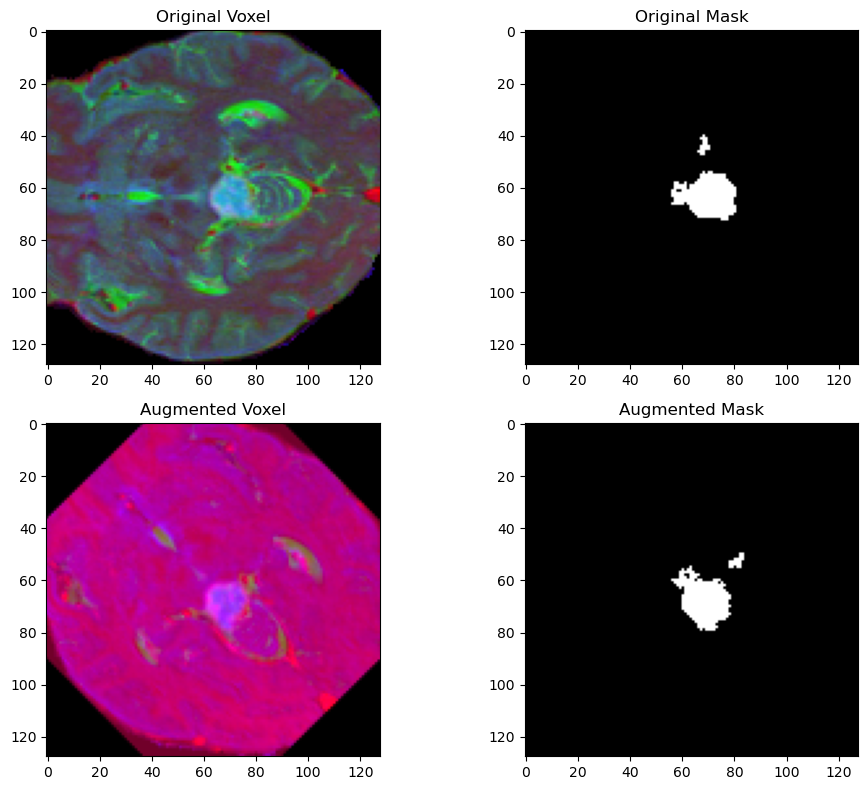

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3868381969978641..1.6696746221535537].


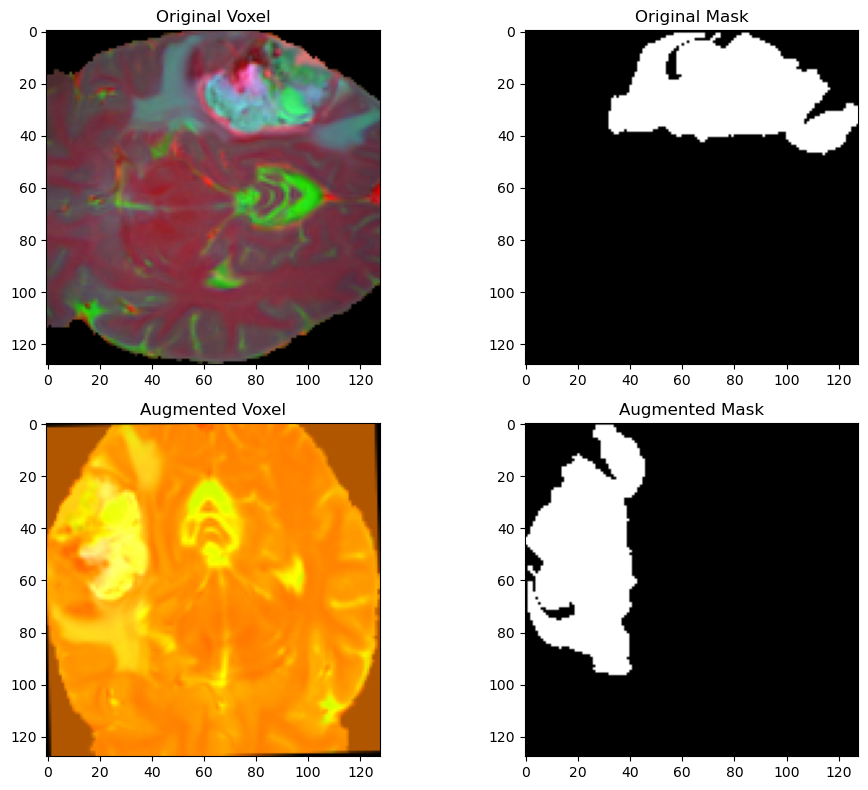

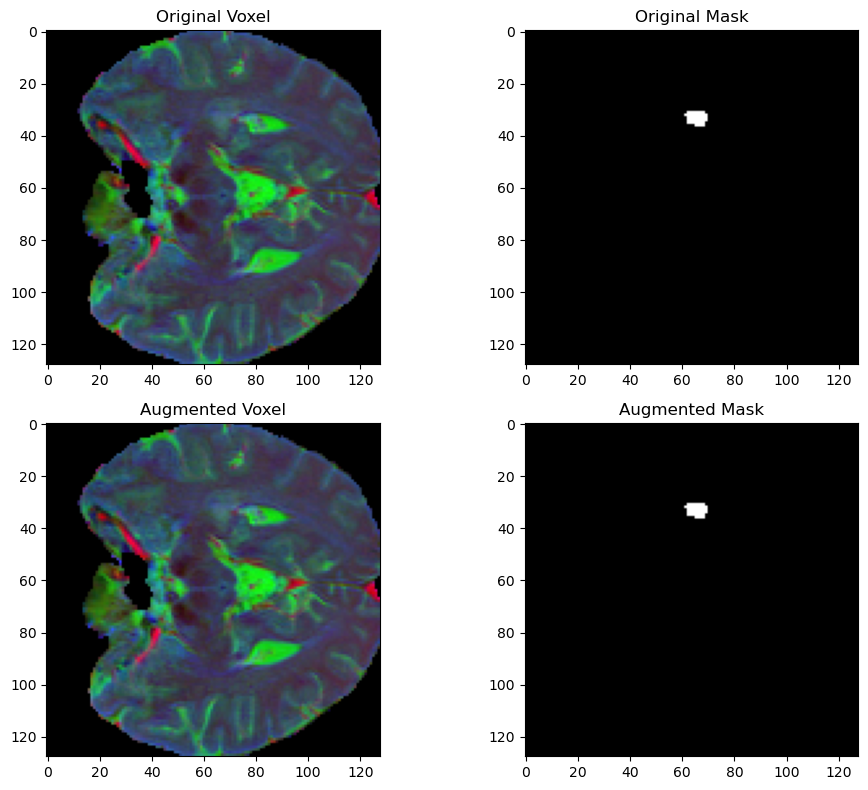

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.853872276743176].


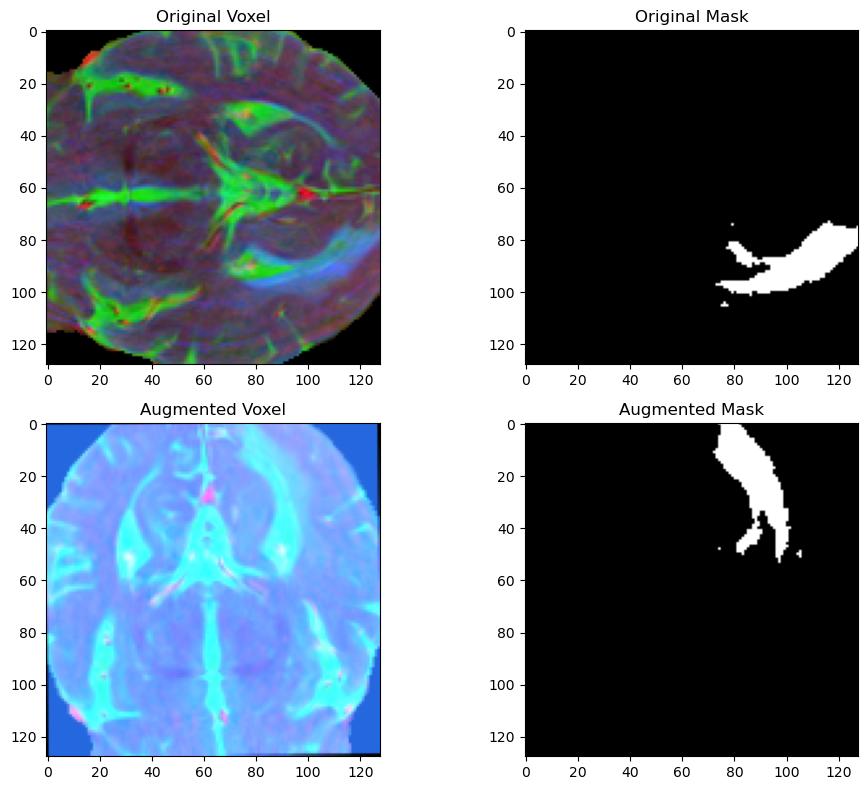

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8426503753936371..1.6339305383338296].


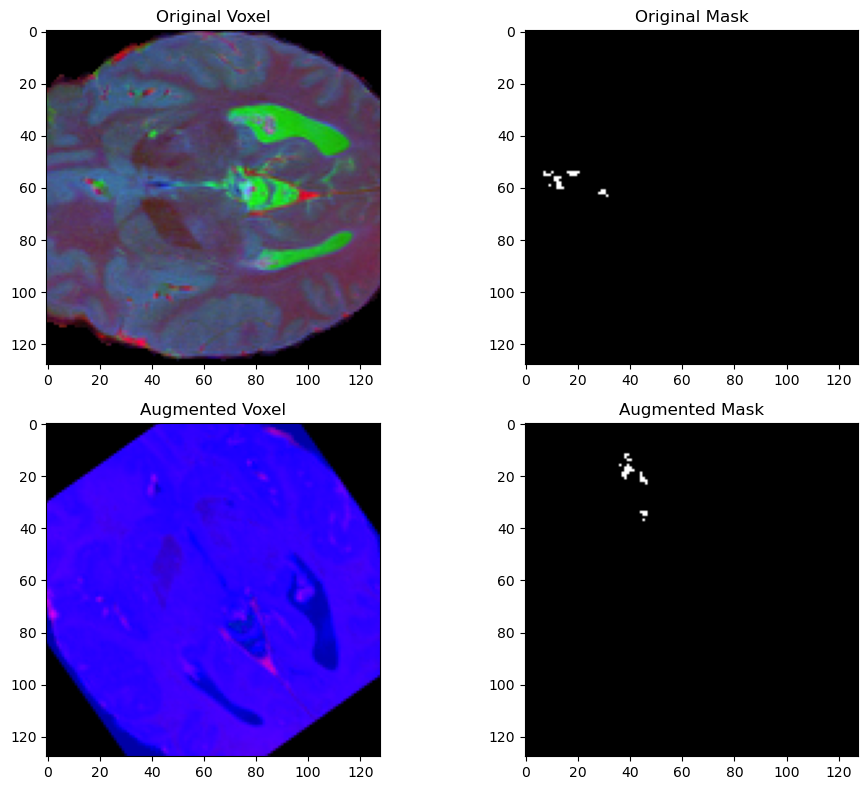

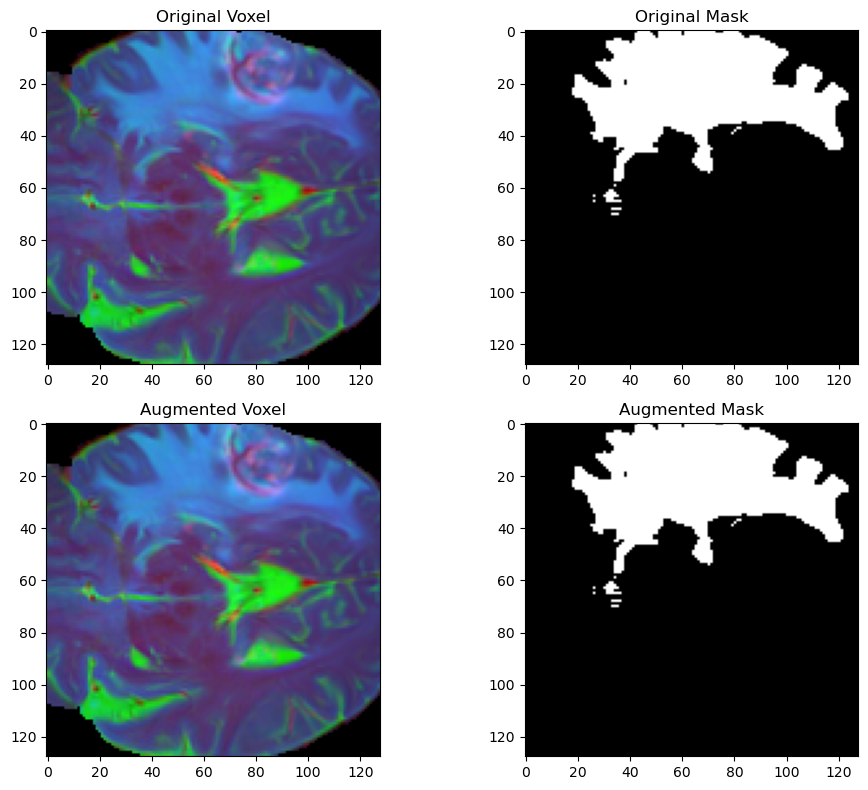

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5274312227136189..1.3675314697182].


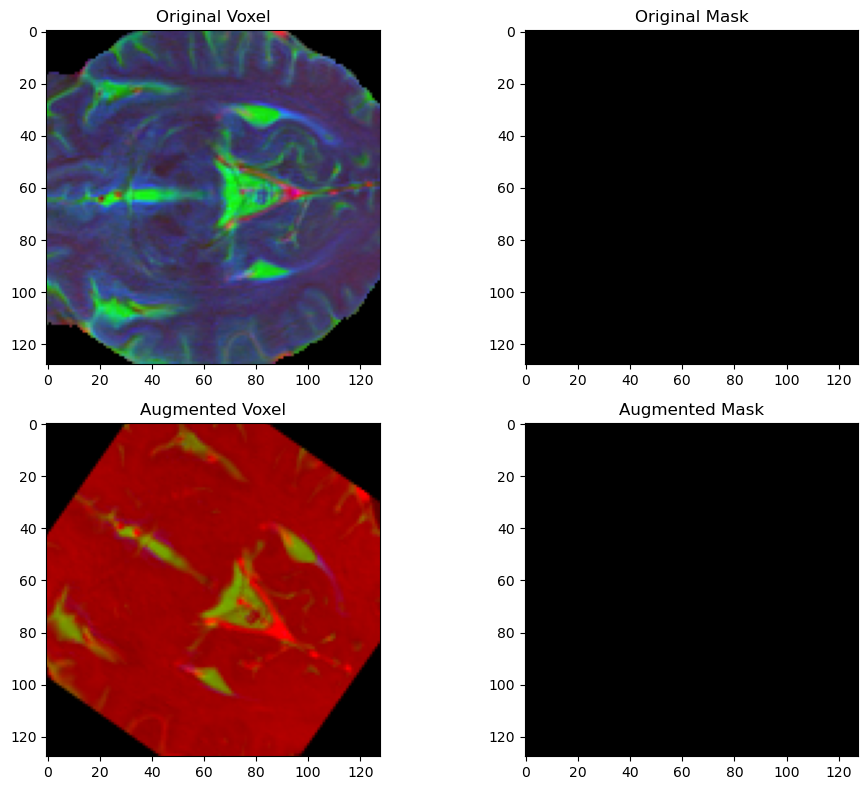

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8086022963198153..1.599108880426117].


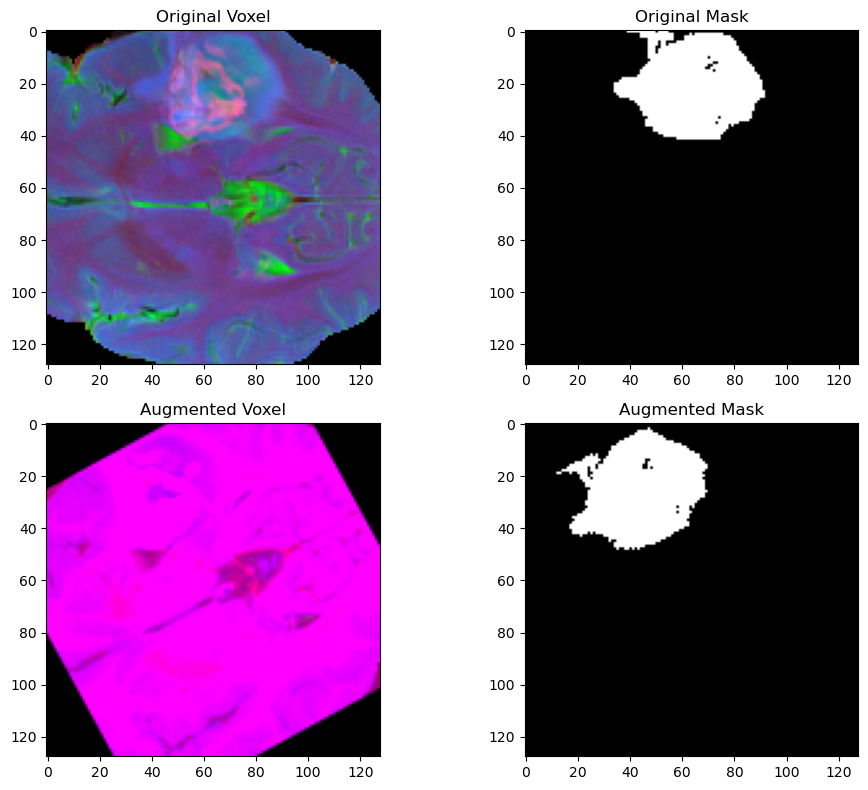

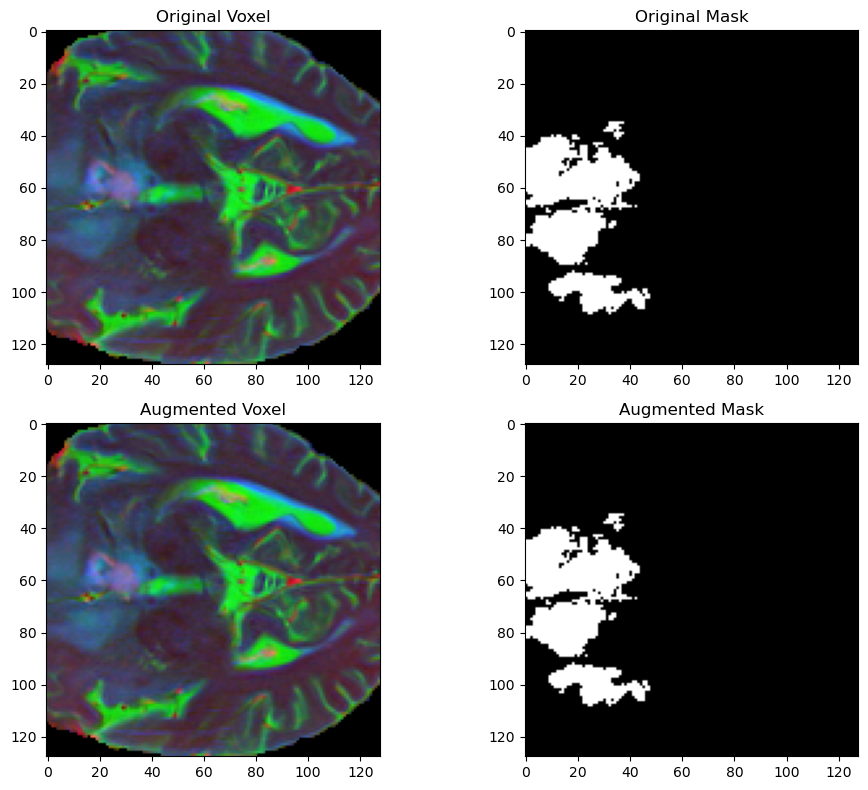

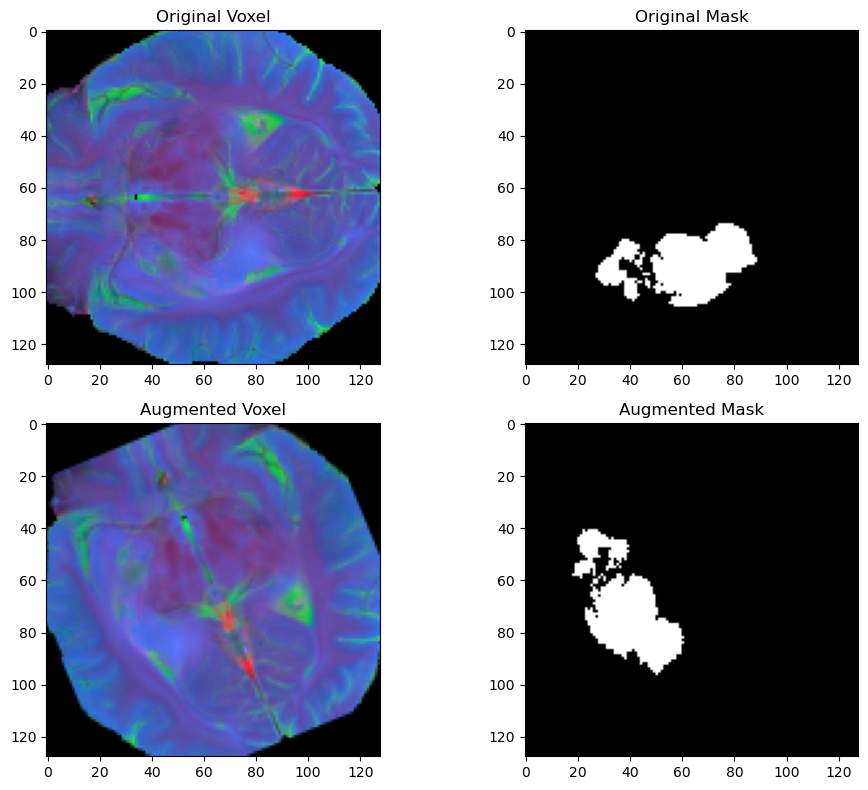

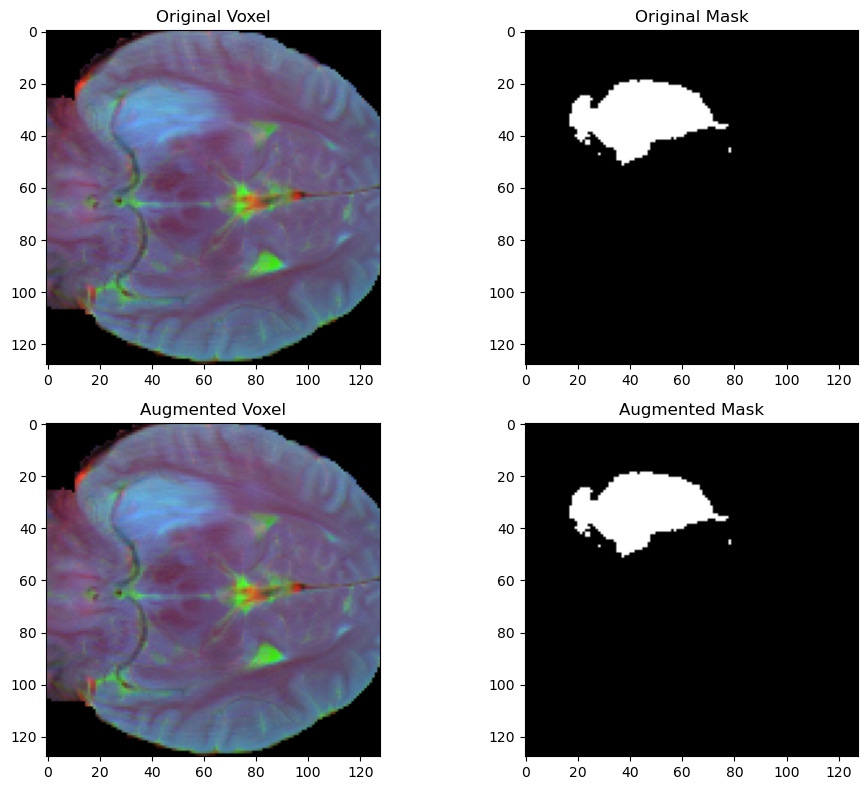

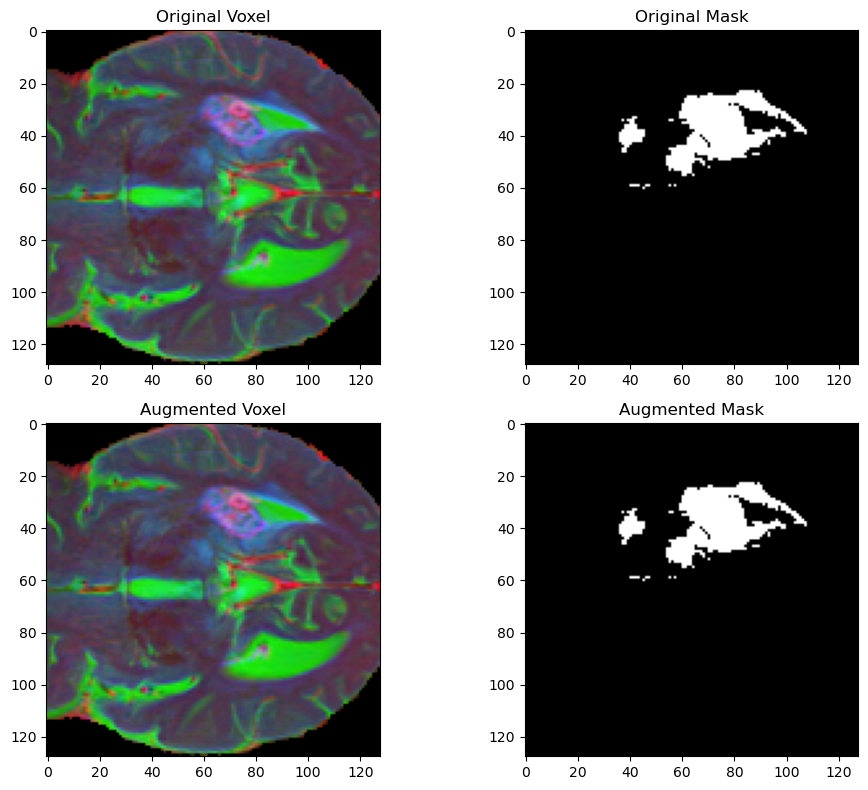

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.27876545760469584..1.8480723085222337].


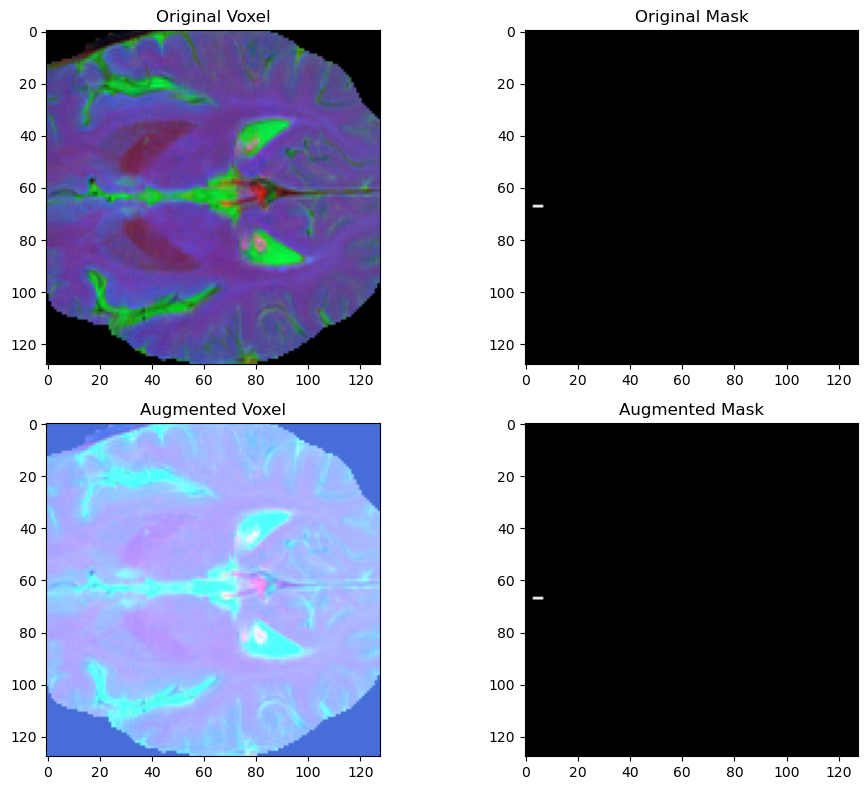

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8342513320613346..1.6131117816590956].


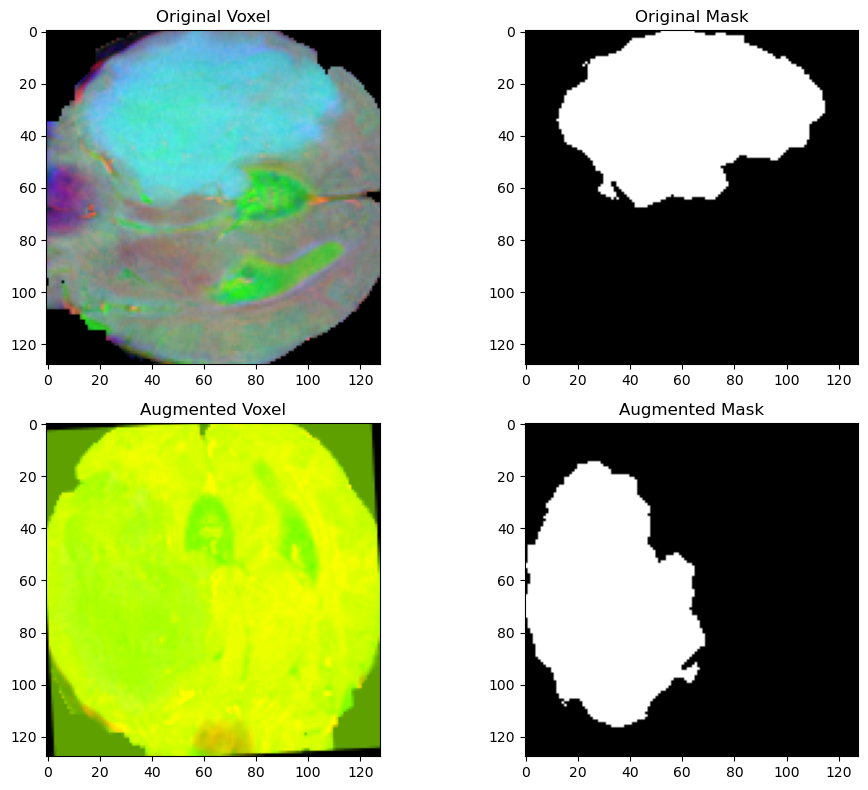

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3051934284492288..1.5376992208553277].


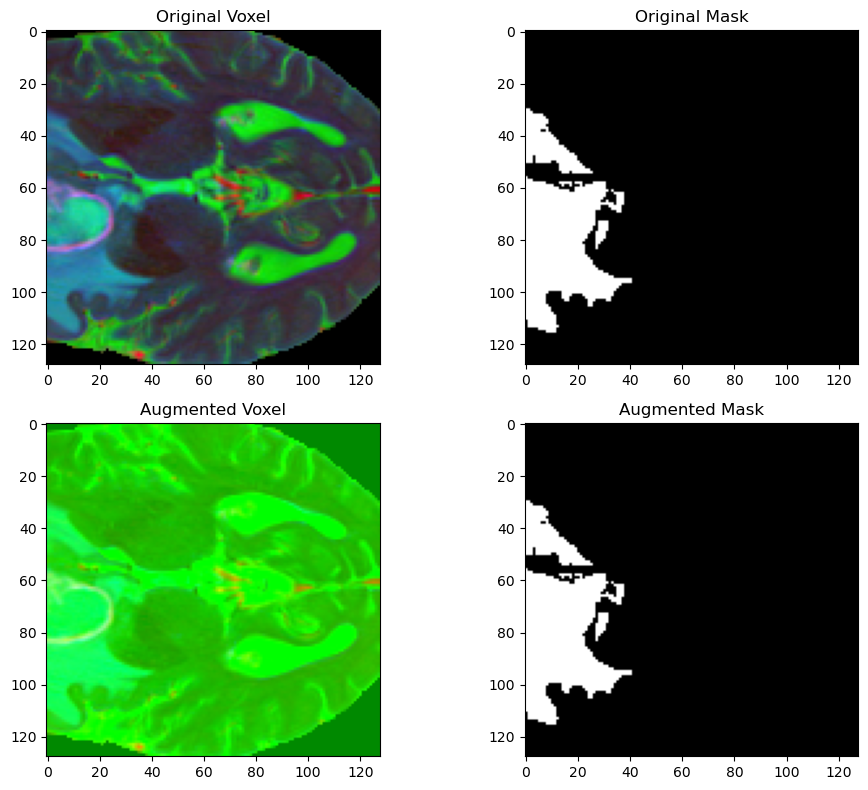

In [34]:
for i in range(15):
    view_augmentations(combined_tensors[i], augmented_combined[i], binary_mask[i], augmented_mask[i])




## Save augmented images

In [35]:
x_aug = augmented_combined

y_aug = augmented_mask

np.save('x_aug.npy', x_aug)
np.save('y_aug', y_aug)